In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
kernels = {
    'linear': lambda x, y: np.dot(x.T, y),
    'squared_exponential': lambda x, y: np.exp(-100 * np.dot((x - y).T, (x - y))),
    'periodic': lambda x, y: np.exp(-np.sin(5 * np.pi * (x - y)) ** 2)
}

In [3]:
# Choose kernel
k = kernels['squared_exponential']

In [4]:
# Choose points at which to sample
x = np.arange(0, 1, 0.005)
n = len(x)

In [5]:
# Build Covariance matrix
C = np.zeros((n , n))
for i in range(n):
    for j in range(n):
        C[i, j] = k(x[i], x[j])

In [8]:
# Factorise the covariance matrix
U, s, V = np.linalg.svd(C)

In [17]:
# Sample from the GP at sample points
u = np.random.randn(n, 1)
z = np.dot(U, np.dot(np.sqrt(np.diag(s)), u))

(-2, 2)

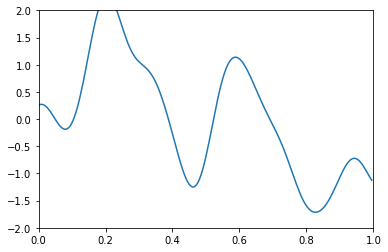

In [18]:
# Plot
plt.plot(x, z)
plt.xlim(0, 1)
plt.ylim(-2, 2)

In [ ]:
observations = [(-4, -2), (-3, 0), (-1, 1), (0, 2), (1, 2), (2, -1)]